In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.eightb.preselection.ranked_quadh
signal = ObjIter([Tree(fn, use_gen=False) for fn in module.signal_list[::3]])
bkg = ObjIter([Tree(module.QCD_B_List, use_gen=False), Tree(module.TTJets, use_gen=False)])

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


In [4]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))

[None, None, None, None, None]

In [6]:
def get_features(t):
  jet_ht=ak.sum(t.jet_ptRegressed,axis=-1)
  X_et=np.sqrt(t.X_pt**2 + t.X_m**2)
  t.extend(
    jet_ht=jet_ht,
    X_et=X_et,
    jet_relht=jet_ht/X_et,
    X_e=np.sqrt(t.X_pt**2*(1+np.sinh(t.X_eta)**2) + t.X_m**2),
  )
(signal+bkg).apply(get_features)

[None, None, None, None, None]

100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


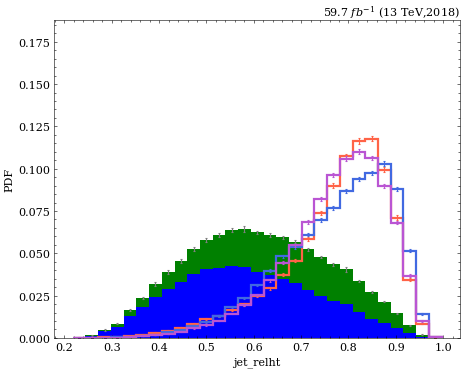

In [7]:
varinfo.X_e = dict(bins=(0,2000,30))
varinfo.X_et = dict(bins=(0,2000,30))
varinfo.jet_ht=dict(bins=(0,2000,30))
study.quick(
    signal + bkg,
    varlist=['jet_relht'],
    efficiency=True,
)

In [7]:
# study.quick2d(
#     signal + bkg,
#     varlist=['X_e','jet_ht'],
#     efficiency=True,
#     contour=True,
#     exe=[plot_histo2d_x_corr],
# )

In [8]:
# study.quick(
#     signal+bkg, efficiency=True,
#     varlist=[lambda t : t.jet_ptRegressed[:,i]/t.jet_ht for i in range(8)],
#     binlist=[(0,0.1,50)]*8,
#     cumulative=-1,correlation=True,
# )
# study.quick(
#     signal+bkg, efficiency=True,
#     varlist=[lambda t : t.jet_ptRegressed[:,i]/t.X_et for i in range(8)],
#     cumulative=-1,correlation=True,
#     binlist=[(0,0.1,50)]*8,

# )
# study.quick(
#     signal+bkg, efficiency=True,
#     varlist=[lambda t : t.jet_ptRegressed[:,i]/t.X_e for i in range(8)],
#     cumulative=-1,correlation=True,
#     binlist=[(0,0.1,50)]*8,

# )

In [9]:
f = signal[0].X_pt[:100]
g = signal[0].X_et[:100]
h = signal[0].X_m[:100]

In [16]:
def dcorr2(f, g):
    fi, fj, fk = ak.unzip(ak.combinations(f, 3, axis=0))
    gi, gj, gk = ak.unzip(ak.combinations(g, 3, axis=0))

    df = np.abs(fi-fj)
    dfp= np.abs(fi-fk)
    dg = np.abs(gi-gj)
    dgp= np.abs(gi-gk)

    fg_dcov2 = ak.mean(df*dg) + ak.mean(df)*ak.mean(dg) - 2*ak.mean(df*dgp)
    ff_dcov2 = ak.mean(df*df) + ak.mean(df)**2 - 2*ak.mean(df*dfp)
    gg_dcov2 = ak.mean(dg*dg) + ak.mean(dg)**2 - 2*ak.mean(dg*dgp)

    print(fg_dcov2, ff_dcov2, gg_dcov2)
    
    return fg_dcov2/np.sqrt(ff_dcov2*gg_dcov2)

In [19]:
dcorr2(f, g)

3398.895325748337 2553.9436265492404 5954.708029639616


0.8715692523186583

In [36]:
f = 100*(2*np.random.rand(100)-1)
g = 100*(2*np.random.rand(100)-1)

dcorr2(f, f**2)

16335.811866763921 2197.9544202139077 5031827.855035394


0.15533470417331663

In [32]:
ak.corr(f, g)

0.053363166772431206